Training classifier...
Training accuracy: 1.000
Test accuracy: 1.000


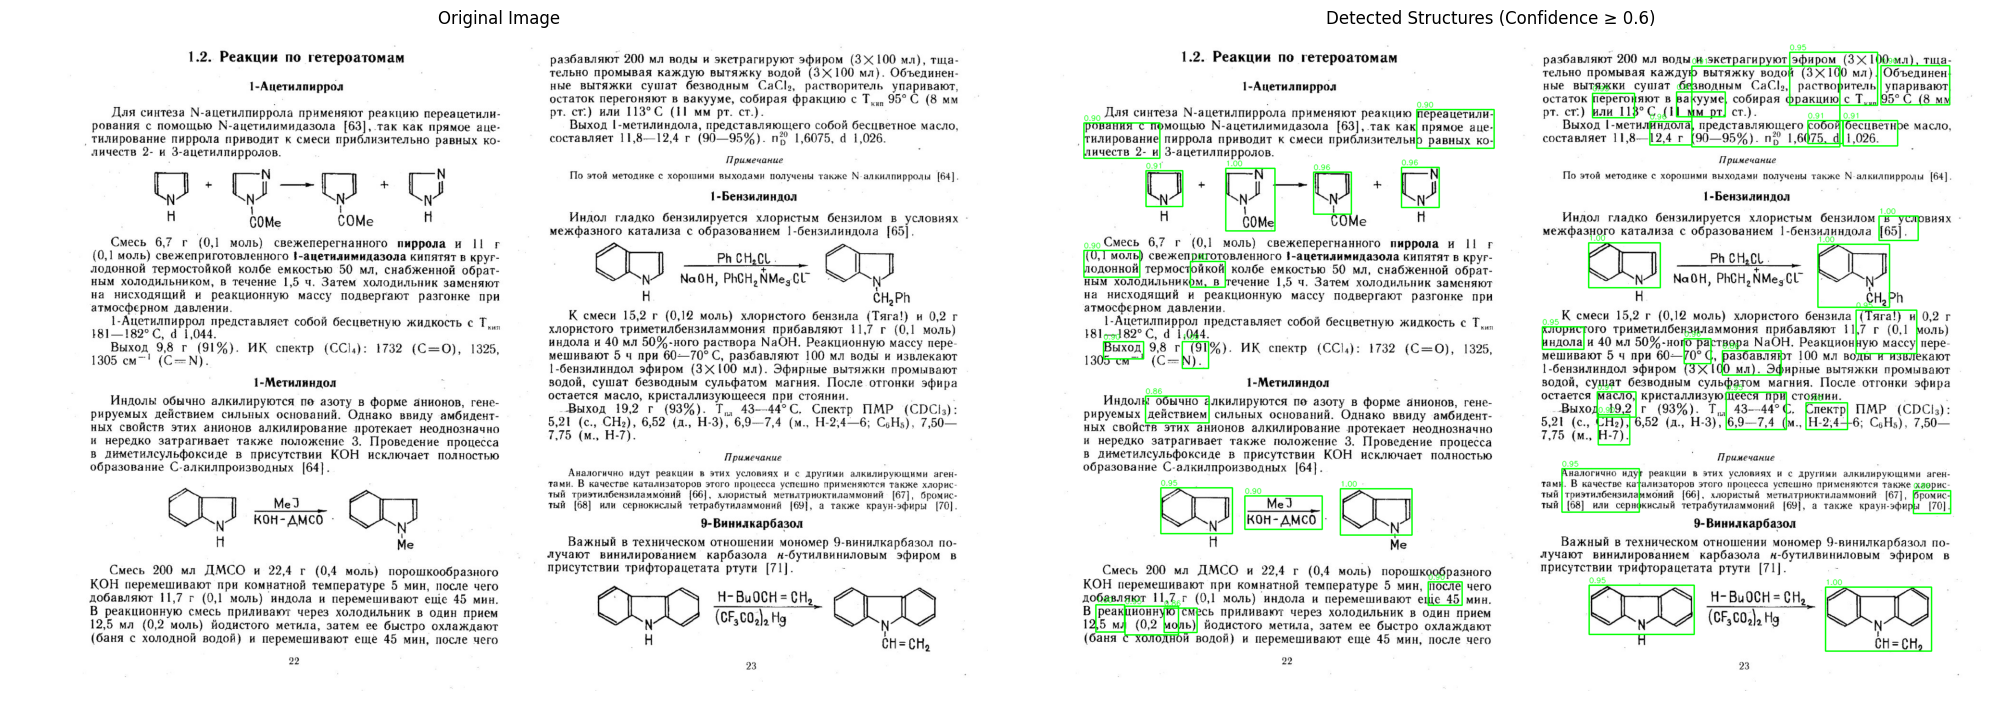

Found 79 chemical structures
Processing page_1.png...
Found 46 chemical structures across all pages


In [2]:
from pytesseract import pytesseract
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.measure import label, regionprops
from skimage.filters import threshold_otsu
from skimage.feature import corner_peaks, local_binary_pattern
from skimage.morphology import skeletonize
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
import joblib
import fitz  # PyMuPDF
from io import BytesIO
from PIL import Image


class ChemicalStructureDetector:
    def __init__(self, min_structure_size=15, model_path=None):
        self.min_size = min_structure_size
        self.classifier = None
        self.feature_names = [
            'area', 'aspect_ratio', 'solidity', 'extent', 'eccentricity',
            'line_density', 'circle_density', 'corner_density', 'junction_density',
            'black_pixel_ratio', 'edge_density', 'skeleton_density',
            'connectivity_components', 'avg_component_size', 'lbp_uniformity',
            'horizontal_lines', 'vertical_lines', 'diagonal_lines',
            'small_circles', 'medium_circles', 'text_like_ratio',
            'hexagon_density', 'bond_density', 'ring_density',
            'arrow_density', 'formula_density', 'symmetry_score'
        ]
        if model_path and os.path.exists(model_path):
            self.classifier = joblib.load(model_path)
        else:
            self._train_classifier()

    def _train_classifier(self):
        print("Training classifier...")
        chem_features = self._generate_chemical_features(500)
        text_features = self._generate_text_features(500)
        X = np.vstack([chem_features, text_features])
        y = np.hstack([np.ones(500), np.zeros(500)])
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42
        )
        self.classifier = RandomForestClassifier(n_estimators=100, max_depth=12, random_state=42)
        self.classifier.fit(X_train, y_train)
        print(f"Training accuracy: {self.classifier.score(X_train, y_train):.3f}")
        print(f"Test accuracy: {self.classifier.score(X_test, y_test):.3f}")
        joblib.dump(self.classifier, 'chemical_structure_classifier.pkl')

    def _generate_chemical_features(self, n_samples):
        """Generate synthetic features for chemical structures"""
        features = []
        for _ in range(n_samples):
            feature = [
                np.random.uniform(300, 3000),    # area
                np.random.uniform(0.5, 2.0),     # aspect_ratio
                np.random.uniform(0.5, 0.9),     # solidity
                np.random.uniform(0.5, 0.9),     # extent
                np.random.uniform(0.2, 0.8),     # eccentricity
                np.random.uniform(0.8, 2.5),     # line_density
                np.random.uniform(0.1, 0.6),     # circle_density
                np.random.uniform(0.4, 1.2),     # corner_density
                np.random.uniform(0.3, 1.0),     # junction_density
                np.random.uniform(0.1, 0.4),     # black_pixel_ratio
                np.random.uniform(0.2, 0.7),     # edge_density
                np.random.uniform(0.05, 0.2),    # skeleton_density
                np.random.uniform(2, 10),        # connectivity_components
                np.random.uniform(30, 200),      # avg_component_size
                np.random.uniform(0.5, 0.9),     # lbp_uniformity
                np.random.uniform(0.1, 0.5),     # horizontal_lines
                np.random.uniform(0.1, 0.5),     # vertical_lines
                np.random.uniform(0.2, 0.6),     # diagonal_lines
                np.random.uniform(0.1, 0.4),     # small_circles
                np.random.uniform(0.0, 0.2),     # medium_circles
                np.random.uniform(0.1, 0.4),     # text_like_ratio
                np.random.uniform(0.2, 0.6),     # hexagon_density
                np.random.uniform(0.4, 1.0),     # bond_density
                np.random.uniform(0.3, 0.8),     # ring_density
                np.random.uniform(0.1, 0.4),     # arrow_density
                np.random.uniform(0.2, 0.6),     # formula_density
                np.random.uniform(0.4, 0.8)      # symmetry_score
            ]
            features.append(feature)
        return np.array(features)
    
    def _detect_brackets(self, binary):
        """Detect square brackets [ ] in the image"""
        contours, _ = cv2.findContours(binary.astype(np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        bracket_count = 0
        for cnt in contours:
            peri = cv2.arcLength(cnt, True)
            approx = cv2.approxPolyDP(cnt, 0.04 * peri, True)
            if len(approx) == 4:  # Brackets often appear as quadrilaterals
                bracket_count += 1
        return bracket_count

    def _generate_text_features(self, n_samples):
        """Generate synthetic features for text regions"""
        features = []
        for _ in range(n_samples):
            feature = [
                np.random.uniform(200, 2000),    # area
                np.random.uniform(3.0, 10.0),    # aspect_ratio
                np.random.uniform(0.85, 0.98),   # solidity
                np.random.uniform(0.8, 0.98),    # extent
                np.random.uniform(0.7, 0.95),    # eccentricity
                np.random.uniform(0.05, 0.3),    # line_density
                np.random.uniform(0.0, 0.05),    # circle_density
                np.random.uniform(0.0, 0.2),     # corner_density
                np.random.uniform(0.0, 0.1),     # junction_density
                np.random.uniform(0.15, 0.35),   # black_pixel_ratio
                np.random.uniform(0.05, 0.25),   # edge_density
                np.random.uniform(0.01, 0.05),   # skeleton_density
                np.random.uniform(5, 20),        # connectivity_components
                np.random.uniform(10, 50),       # avg_component_size
                np.random.uniform(0.8, 0.98),    # lbp_uniformity
                np.random.uniform(0.6, 0.9),     # horizontal_lines
                np.random.uniform(0.7, 0.95),    # vertical_lines
                np.random.uniform(0.05, 0.2),    # diagonal_lines
                np.random.uniform(0.0, 0.02),    # small_circles
                np.random.uniform(0.0, 0.01),    # medium_circles
                np.random.uniform(0.8, 0.98),    # text_like_ratio
                np.random.uniform(0.0, 0.05),    # hexagon_density
                np.random.uniform(0.0, 0.05),    # bond_density
                np.random.uniform(0.0, 0.05),    # ring_density
                np.random.uniform(0.0, 0.05),    # arrow_density
                np.random.uniform(0.0, 0.05),    # formula_density
                np.random.uniform(0.05, 0.2)     # symmetry_score
            ]
            features.append(feature)
        return np.array(features)

    def extract_features(self, roi):
        """Extract comprehensive features from a region of interest"""
        if roi.size == 0:
            return np.zeros(len(self.feature_names))
        if len(roi.shape) == 3:
            roi = cv2.cvtColor(roi, cv2.COLOR_BGR2GRAY)
        h, w = roi.shape
        area = h * w
        aspect_ratio = w / h if h != 0 else 0

        try:
            thresh_val = threshold_otsu(roi)
            binary = roi < thresh_val
        except:
            binary = roi < 128

        binary_uint8 = binary.astype(np.uint8) * 255
        edges = cv2.Canny(roi, 50, 150)
        labeled = label(binary)
        props = regionprops(labeled)

        if not props:
            return np.zeros(len(self.feature_names))

        main_region = max(props, key=lambda x: x.area)
        solidity = main_region.solidity
        extent = main_region.extent
        eccentricity = main_region.eccentricity
        edge_density = np.sum(edges > 0) / area if area > 0 else 0
        skeleton = skeletonize(binary)
        skeleton_density = np.sum(skeleton) / area if area > 0 else 0

        lines = cv2.HoughLinesP(edges, 1, np.pi/180, 20, minLineLength=10, maxLineGap=5)
        line_density = len(lines) / area * 10000 if lines is not None else 0

        hexagon_count = 0
        contours, _ = cv2.findContours(binary_uint8, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        for cnt in contours:
            peri = cv2.arcLength(cnt, True)
            approx = cv2.approxPolyDP(cnt, 0.04 * peri, True)
            if len(approx) == 6:
                hexagon_count += 1
        hexagon_density = hexagon_count / area * 10000 if area > 0 else 0

        circles = cv2.HoughCircles(roi, cv2.HOUGH_GRADIENT, dp=1.2, minDist=10,
                                   param1=30, param2=15, minRadius=2, maxRadius=15)
        small_circles = len(circles[0]) if circles is not None else 0
        circle_density = small_circles / area * 10000 if area > 0 else 0

        try:
            corners = corner_peaks(cv2.cornerHarris(roi.astype(np.float32), 2, 3, 0.04),
                                   min_distance=3, threshold_abs=0.01)
            corner_density = len(corners) / area * 10000 if area > 0 else 0
        except:
            corner_density = 0

        try:
            kernel = np.array([[-1, -1, -1], [-1, 8, -1], [-1, -1, -1]], dtype=np.float32)
            junctions = cv2.filter2D(edges.astype(np.float32), -1, kernel)
            junction_density = np.sum(junctions > 50) / area * 10000 if area > 0 else 0
        except:
            junction_density = 0

        bond_count = 0
        if lines is not None:
            for line in lines:
                x1, y1, x2, y2 = line[0]
                length = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)
                if 5 < length < 30:
                    bond_count += 1
        bond_density = bond_count / area * 10000 if area > 0 else 0

        ring_count = 0
        for cnt in contours:
            peri = cv2.arcLength(cnt, True)
            approx = cv2.approxPolyDP(cnt, 0.04 * peri, True)
            if 3 <= len(approx) <= 8 and cv2.contourArea(cnt) > 30:
                ring_count += 1
        ring_density = ring_count / area * 10000 if area > 0 else 0

        arrow_count = 0
        if lines is not None:
            for line in lines:
                x1, y1, x2, y2 = line[0]
                length = np.sqrt((x2 - x1)**2 + (y2 - y1)**2)
                angle = np.arctan2(y2 - y1, x2 - x1) * 180 / np.pi
                if (length > 30 and abs(angle) < 10) or abs(angle) > 170:
                    arrow_count += 1
        arrow_density = arrow_count / area * 10000 if area > 0 else 0

        formula_count = 0
        num_labels, labels = cv2.connectedComponents(binary_uint8)
        for label_id in range(1, num_labels):
            component = (labels == label_id).astype(np.uint8)
            if 0.1 < np.sum(component) / binary.size < 0.3:
                formula_count += 1
        formula_density = formula_count / area * 10000 if area > 0 else 0

        symmetry_score = 0
        if binary.size > 0:
            binary_uint8 = binary.astype(np.uint8) * 255
            h_sym = np.sum(np.bitwise_xor(binary_uint8, np.fliplr(binary_uint8))) / (binary.size * 255)
            v_sym = np.sum(np.bitwise_xor(binary_uint8, np.flipud(binary_uint8))) / (binary.size * 255)
            symmetry_score = 1 - (h_sym + v_sym) / 2

        try:
            lbp = local_binary_pattern(roi, 8, 1, method='uniform')
            lbp_uniformity = np.sum(lbp <= 8) / area if area > 0 else 0
        except:
            lbp_uniformity = 0

        hor_lines = ver_lines = dia_lines = 0
        if lines is not None:
            for line in lines:
                x1, y1, x2, y2 = line[0]
                angle = np.arctan2(y2 - y1, x2 - x1) * 180 / np.pi
                if abs(angle) < 15 or abs(angle) > 165:
                    hor_lines += 1
                elif 75 < abs(angle) < 105:
                    ver_lines += 1
                else:
                    dia_lines += 1
        total_lines = max(1, len(lines)) if lines is not None else 1
        hor_lines /= total_lines
        ver_lines /= total_lines
        dia_lines /= total_lines

        try:
            dist_transform = cv2.distanceTransform(binary_uint8, cv2.DIST_L2, 3)
            stroke_widths = dist_transform[binary]
            stroke_variation = np.std(stroke_widths) / (np.mean(stroke_widths) + 1e-6) if len(stroke_widths) > 0 else 0
        except:
            stroke_variation = 0

        try:
            h_prof = np.sum(binary, axis=0)
            v_prof = np.sum(binary, axis=1)
            spacing_score = (self._calculate_spacing_regularity(h_prof) +
                             self._calculate_spacing_regularity(v_prof)) / 2
            stroke_uniformity = 1 - stroke_variation
            text_like_ratio = (stroke_uniformity + spacing_score) / 2
        except:
            text_like_ratio = 0

        return np.array([
            area, aspect_ratio, solidity, extent, eccentricity,
            line_density, circle_density, corner_density, junction_density,
            np.sum(binary)/area if area > 0 else 0, edge_density, skeleton_density,
            len(props), np.mean([p.area for p in props]) if props else 0, lbp_uniformity,
            hor_lines, ver_lines, dia_lines,
            small_circles, 0, text_like_ratio,
            hexagon_density, bond_density, ring_density,
            arrow_density, formula_density, symmetry_score
        ])

    def _detect_text_paragraphs(self, image):
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        _, binary = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY_INV + cv2.THRESH_OTSU)
        hor_proj = np.sum(binary, axis=1)
        threshold = 0.5 * np.max(hor_proj)
        text_mask = np.zeros_like(gray)
        in_text = False
        start_idx = 0
        for i, val in enumerate(hor_proj):
            if val > threshold and not in_text:
                in_text = True
                start_idx = i
            elif val <= threshold and in_text:
                in_text = False
                if i - start_idx > 20:
                    text_mask[start_idx:i, :] = 255
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (30, 5))
        text_mask = cv2.dilate(text_mask, kernel, iterations=1)
        return text_mask

    def _calculate_spacing_regularity(self, profile):
        peaks = []
        for i in range(1, len(profile) - 1):
            if profile[i] > profile[i-1] and profile[i] > profile[i+1]:
                peaks.append(i)
        if len(peaks) < 2:
            return 0
        gaps = np.diff(peaks)
        return 1 / (1 + np.std(gaps) / (np.mean(gaps) + 1e-6))

    def segment_image(self, image_path, output_folder=None, confidence_threshold=0.6):
        try:
            image = cv2.imread(image_path)
            if image is None:
                raise ValueError(f"Could not read image: {image_path}")
            result_image = image.copy()
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            gray = cv2.equalizeHist(gray)
            gray = cv2.medianBlur(gray, 3)
            text_mask = self._detect_text_paragraphs(image)
            non_text_mask = cv2.bitwise_not(text_mask)
            masked_gray = cv2.bitwise_and(gray, gray, mask=non_text_mask)
            binary = cv2.adaptiveThreshold(masked_gray, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
                                           cv2.THRESH_BINARY_INV, 7, 2)
            kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (2, 2))
            cleaned = cv2.morphologyEx(binary, cv2.MORPH_OPEN, kernel, iterations=1)
            contours, _ = cv2.findContours(cleaned, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
            predictions = []

            for cnt in contours:
                x, y, w, h = cv2.boundingRect(cnt)
                if w < self.min_size or h < self.min_size:
                    continue
                if w > image.shape[1] * 0.9 or h > image.shape[0] * 0.9:
                    continue
                roi = gray[y:y+h, x:x+w]
                if roi.size == 0:
                    continue
                features = self.extract_features(roi)
                if features[1] > 5.0:
                    continue
                if self.classifier is not None:
                    prob = self.classifier.predict_proba(features.reshape(1, -1))[0]
                    confidence = prob[1]
                    if confidence >= confidence_threshold:
                        predictions.append({
                            'bbox': (x, y, w, h),
                            'confidence': confidence,
                            'features': features
                        })

            # Filter by relative size
            if predictions:
                areas = [p['bbox'][2] * p['bbox'][3] for p in predictions]
                avg_area = np.mean(areas)
                final_predictions = [p for p in predictions if p['bbox'][2] * p['bbox'][3] >= avg_area]
            else:
                final_predictions = []

            # Draw only green boxes (high-confidence)
            structures = [image[p['bbox'][1]:p['bbox'][1]+p['bbox'][3], p['bbox'][0]:p['bbox'][0]+p['bbox'][2]] for p in final_predictions]

            for pred in final_predictions:
                x, y, w, h = pred['bbox']
                confidence = pred['confidence']
                if confidence > 0.8:
                    color = (0, 255, 0)
                    cv2.rectangle(result_image, (x, y), (x + w, y + h), color, 2)
                    cv2.putText(result_image, f"{confidence:.2f}", (x, y - 5),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1, cv2.LINE_AA)
                    if output_folder and confidence >= 0.7:
                        os.makedirs(output_folder, exist_ok=True)
                        output_path = os.path.join(output_folder, f"struct_{x}_{y}.png")
                        cv2.imwrite(output_path, image[y:y+h, x:x+w])

            if output_folder:
                os.makedirs(output_folder, exist_ok=True)
                result_path = os.path.join(output_folder, "detection_result.png")
                cv2.imwrite(result_path, result_image)
                cv2.imwrite(os.path.join(output_folder, "text_mask.png"), text_mask)

            return structures, final_predictions, result_image

        except Exception as e:
            print(f"Error processing image: {e}")
            return [], [], None

    def visualize_detections(self, image_path, confidence_threshold=0.6):
        image = cv2.imread(image_path)
        if image is None:
            raise ValueError(f"Image not found: {image_path}")
        structures, predictions, result_image = self.segment_image(image_path, confidence_threshold=confidence_threshold)
        plt.figure(figsize=(20, 10))
        plt.subplot(1, 2, 1)
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.title("Original Image")
        plt.axis('off')
        plt.subplot(1, 2, 2)
        plt.imshow(cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB))
        plt.title(f"Detected Structures (Confidence ≥ {confidence_threshold})")
        plt.axis('off')
        plt.tight_layout()
        plt.show()
        return structures, predictions

    def process_pdf(self, pdf_path, output_folder, dpi=200):
        temp_folder = os.path.join(output_folder, "temp_pages")
        os.makedirs(temp_folder, exist_ok=True)
        doc = fitz.open(pdf_path)
        for page_num in range(len(doc)):
            page = doc.load_page(page_num)
            zoom = dpi / 72
            mat = fitz.Matrix(zoom, zoom)
            pix = page.get_pixmap(matrix=mat)
            img = Image.open(BytesIO(pix.tobytes("png"))).convert("RGB")
            img.save(os.path.join(temp_folder, f"page_{page_num+1}.png"))
        results = []
        for filename in sorted(os.listdir(temp_folder)):
            if filename.lower().endswith(('.png', '.jpg', '.jpeg')):
                page_path = os.path.join(temp_folder, filename)
                print(f"Processing {filename}...")
                structures, predictions, _ = self.segment_image(page_path, os.path.join(output_folder, f"{filename.split('.')[0]}_structures"), confidence_threshold=0.6)
                results.append({
                    'page': filename,
                    'structures_found': len(structures),
                    'predictions': predictions
                })
        return results


if __name__ == "__main__":
    detector = ChemicalStructureDetector(min_structure_size=15)
    test_image = "/Users/johnsnow/Downloads/chemstru_recognition/data/sample.jpg"
    if os.path.exists(test_image):
        structures, predictions = detector.visualize_detections(test_image, confidence_threshold=0.6)
        print(f"Found {len(structures)} chemical structures")
    test_pdf = "/Users/johnsnow/Downloads/chemstru_recognition/data/sample.pdf"
    if os.path.exists(test_pdf):
        results = detector.process_pdf(test_pdf, "pdf_results")
        total_structures = sum(r['structures_found'] for r in results)
        print(f"Found {total_structures} chemical structures across all pages")